# *Comparing Regression models with binding free energy calculations data*

### In this NoteBook, the statistical analysis will be performed around data from binding free energy (deltaG) collected for different molecular targets interacting with several bioactive compounds. The deltaG values from the experiment and two computational methods (FEP and TI) are compared, using regression analysis, and grouped according to molecular target.

In [155]:
pip install pandas matplotlib seaborn numpy scipy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy.stats import norm, pearsonr
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from collections import namedtuple
from math import sqrt
import warnings

In [157]:
xls_name = "fep-vs-gti-d-G-SI.xlsx"
df_dict = pd.read_excel(xls_name,sheet_name=None,header=None)

In [158]:
def get_data_from_sheet(df_dict, sheet_name, col_names):
    df = df_dict[sheet_name]
    df = df[df.columns[15:18]]
    col_names = ["Experimental_dG","FEP_dG","TI_dG"]
    df.columns = col_names
    df = df.dropna()
    df = df.query("Experimental_dG > -20")
    rows,_ = df.shape
    df.insert(0,"Target",[sheet_name]*rows)
    df.insert(1,"ID",[f"{sheet_name}_{x}" for x in range(0,rows)])
    return df

In [163]:
pd.options.display.float_format = '{:,.2f}'.format

In [165]:
sheet_names = df_dict.keys()
col_names = ["Experimental_dG","FEP_dG","TI_dG"]
big_df = pd.DataFrame(columns=["Target","ID"]+col_names)
for sheet in sheet_names:
    tmp_df = get_data_from_sheet(df_dict,sheet,col_names)
    big_df = pd.concat([big_df, tmp_df])   
big_df.sort_values("Target",inplace=True)

/var/folders/qn/1xv8rtz13z55l58_s06hqhhc0000gn/T/ipykernel_29979/3511782710.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat([big_df, tmp_df])


In [167]:
big_df.head()

,Target,ID,Experimental_dG,FEP_dG,TI_dG
12,bace,bace_12,-8.53,-6.76,-8.27
30,bace,bace_30,-7.84,-7.40,-7.40
29,bace,bace_29,-9.01,-7.93,-7.80
28,bace,bace_28,-8.25,-7.01,-9.72
27,bace,bace_27,-9.10,-10.14,-10.16


In [169]:
big_df.to_csv("~/fep_comparison.csv",index=False)

In [171]:
mdf = big_df.melt(id_vars=["Target","ID","Experimental_dG"])
mdf["DataSet"] = mdf.Target + "_" + mdf.variable.str.replace("_dG","")
mdf.sort_values("DataSet",inplace=True)
cols = list(mdf.columns)
cols[4] = "Predicted_dG"
mdf.columns = cols

In [173]:
mdf.head()

,Target,ID,Experimental_dG,variable,Predicted_dG,DataSet
0,bace,bace_12,-8.53,FEP_dG,-6.76,bace_FEP
20,bace,bace_10,-9.69,FEP_dG,-9.38,bace_FEP
21,bace,bace_9,-8.72,FEP_dG,-8.73,bace_FEP
22,bace,bace_0,-8.83,FEP_dG,-8.82,bace_FEP
23,bace,bace_1,-9.11,FEP_dG,-8.90,bace_FEP


In [175]:
mdf["Method"] = [x.replace("_dG","") for x in mdf.variable.values]

In [177]:
mdf.head()

,Target,ID,Experimental_dG,variable,Predicted_dG,DataSet,Method
0,bace,bace_12,-8.53,FEP_dG,-6.76,bace_FEP,FEP
20,bace,bace_10,-9.69,FEP_dG,-9.38,bace_FEP,FEP
21,bace,bace_9,-8.72,FEP_dG,-8.73,bace_FEP,FEP
22,bace,bace_0,-8.83,FEP_dG,-8.82,bace_FEP,FEP
23,bace,bace_1,-9.11,FEP_dG,-8.90,bace_FEP,FEP


In [179]:
def pearson_confidence(r, num, interval=0.95):
    """
    Calculate upper and lower 95% CI for a Pearson r (not R**2)
    Inspired by https://stats.stackexchange.com/questions/18887
    :param r: Pearson's R
    :param num: number of data points
    :param interval: confidence interval (0-1.0)
    :return: lower bound, upper bound
    """
    stderr = 1.0 / math.sqrt(num - 3)
    interval = interval + (1-interval)/2
    z_score = norm.ppf(interval)
    delta = z_score * stderr
    lower = math.tanh(math.atanh(r) - delta)
    upper = math.tanh(math.atanh(r) + delta)
    return lower, upper

In [181]:
gb = big_df.groupby("Target")
res = []
for k,v in gb:
    num = len(v.Experimental_dG)
    r_FEP = pearsonr(v.Experimental_dG,v.FEP_dG)[0]
    r_TI = pearsonr(v.Experimental_dG,v.TI_dG)[0]
    lb_FEP, ub_FEP = pearson_confidence(r_FEP,num)
    lb_TI, ub_TI = pearson_confidence(r_TI,num)
    # Currently calculate Pearson r, use the line below to get R**2
    #res.append([k,len(v)]+[x**2 for x in [lb_FEP,r_FEP,ub_FEP,lb_TI,r_TI,ub_TI]])
    res.append([k,len(v)]+[x for x in [lb_FEP,r_FEP,ub_FEP,lb_TI,r_TI,ub_TI]])
res_df = pd.DataFrame(res,columns=["Target","Num","FEP_LB","FEP Correlation","FEP_UB","TI_LB","TI Correlation","TI_UB"])

In [183]:
res_df

,Target,Num,FEP_LB,FEP Correlation,FEP_UB,TI_LB,TI Correlation,TI_UB
0,bace,36,0.61,0.78,0.88,0.12,0.43,0.67
1,cdk2,16,-0.03,0.48,0.79,-0.03,0.47,0.78
2,jnk1,21,0.65,0.84,0.94,0.05,0.47,0.75
3,mcl1,42,0.61,0.77,0.87,0.43,0.65,0.80
4,p38a,34,0.40,0.65,0.81,0.05,0.38,0.64
5,ptp1b,23,0.59,0.80,0.91,0.42,0.71,0.87
6,thrombin,11,0.18,0.71,0.92,0.28,0.76,0.93
7,tyk2,16,0.71,0.89,0.96,0.11,0.57,0.83


In [185]:
melt_res_df = res_df[["Target","FEP Correlation","TI Correlation"]].melt(id_vars="Target")
melt_res_df.sort_values("Target",inplace=True)

In [28]:
melt_res_df

,Target,variable,value
0,bace,FEP Correlation,0.78
8,bace,TI Correlation,0.43
1,cdk2,FEP Correlation,0.48
9,cdk2,TI Correlation,0.47
2,jnk1,FEP Correlation,0.84
10,jnk1,TI Correlation,0.47
3,mcl1,FEP Correlation,0.77
11,mcl1,TI Correlation,0.65
4,p38a,FEP Correlation,0.65
12,p38a,TI Correlation,0.38


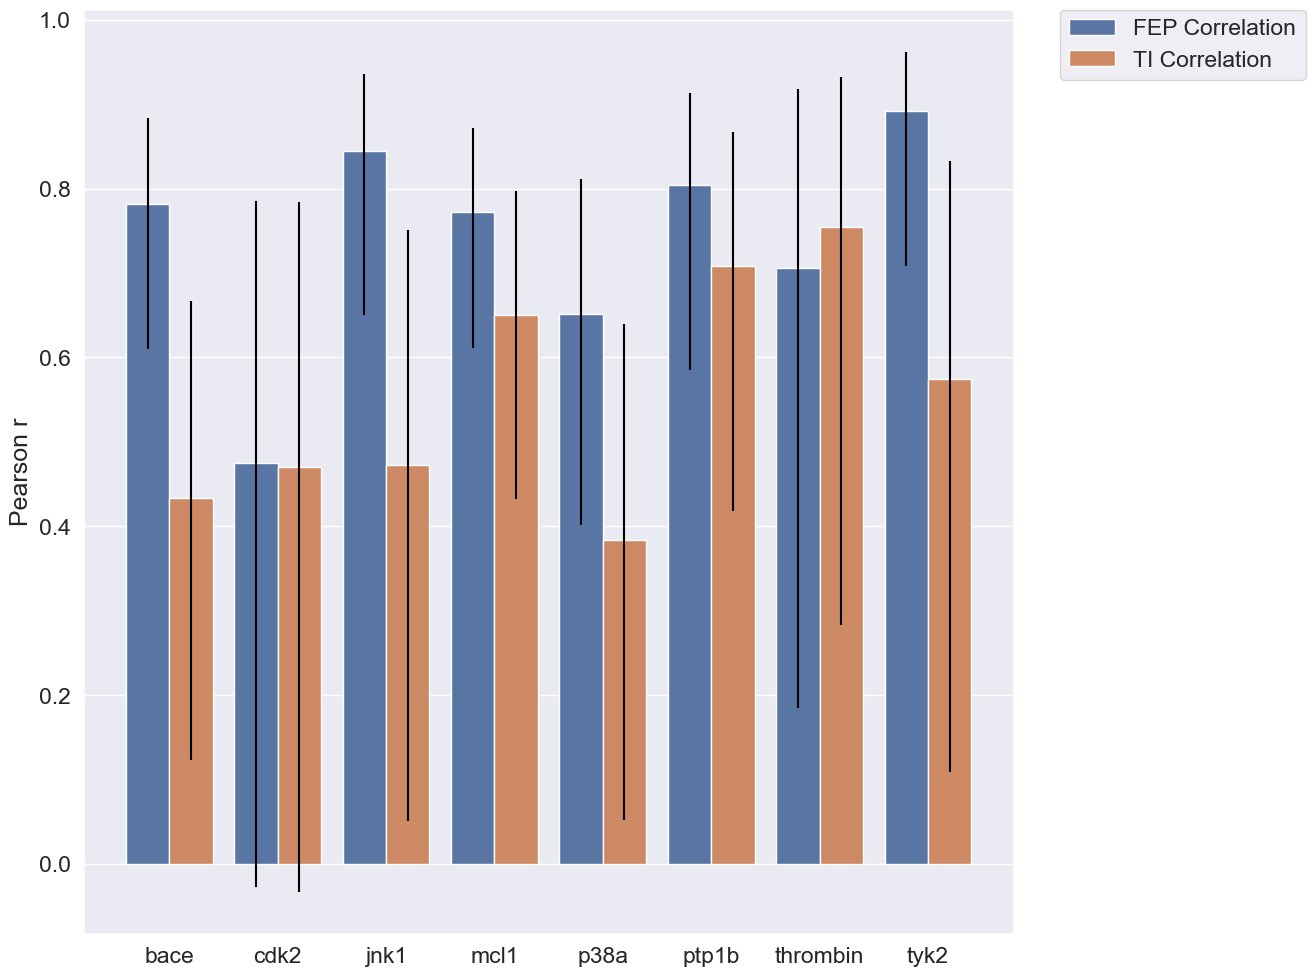

In [29]:
sns.set(rc={'figure.figsize':(12,12)},font_scale=1.5)
ax = sns.barplot(x="Target",y="value",hue="variable",data=melt_res_df)
x_pos = np.arange(8)-0.2
y_val = res_df["FEP Correlation"]
lb = y_val - res_df.FEP_LB
ub = res_df.FEP_UB - y_val
ax.errorbar(x_pos,y_val,yerr=[lb,ub],fmt="none",capsize=0,color='black')
x_pos = np.arange(8)+0.2
y_val = res_df["TI Correlation"]
lb = y_val - res_df.TI_LB
ub = res_df.TI_UB - y_val
a = ax.errorbar(x_pos,y_val,yerr=[lb,ub],fmt="none",capsize=0,color='black')
handles, labels = ax.get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=handles[0:2], labels=labels[0:2])
_ = ax.set(xlabel='', ylabel="Pearson r")

In [30]:
delta = res_df["FEP Correlation"].values-res_df["TI Correlation"].values
np.mean(delta)/np.std(delta)

1.2137416942335348

In [31]:
def d_to_probability(d):
    return 0.25 * abs(d) + 0.5 
d_to_probability(1.2)

0.8

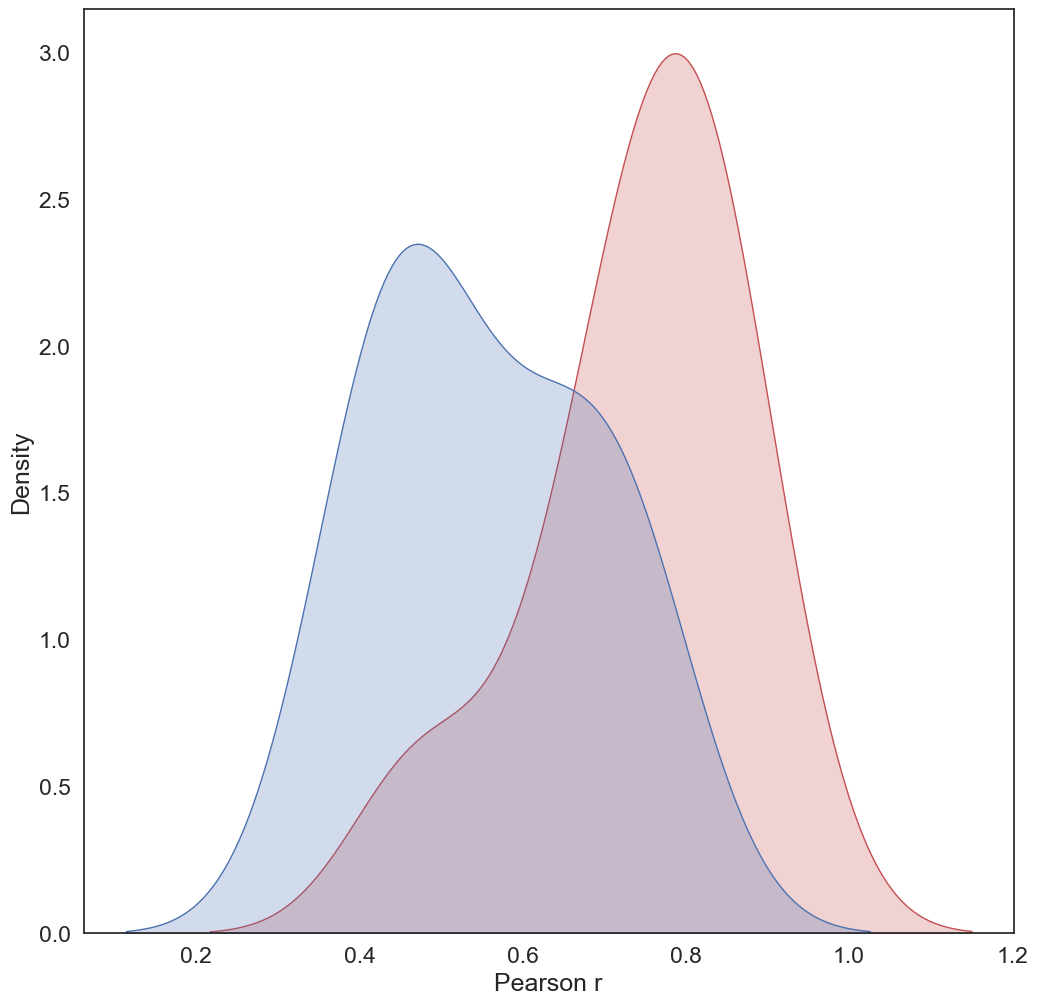

In [32]:
sns.set(font_scale=1.5)
sns.set_style("white")
sns.kdeplot(res_df["FEP Correlation"],color="r",fill=True)
ax = sns.kdeplot(res_df["TI Correlation"],color="b",fill=True)
_ = ax.set(xlabel="Pearson r",ylabel="Density")

In [33]:
xls_name = "fep-vs-gti-d-G-SI.xlsx"
df_dict = pd.read_excel(xls_name,sheet_name=None,header=None)

In [34]:
def get_data_from_sheet(df_dict, sheet_name, col_names):
    df = df_dict[sheet_name]
    df = df[df.columns[15:18]]
    col_names = ["Experimental_dG","FEP_dG","TI_dG"]
    df.columns = col_names
    df = df.dropna()
    df = df.query("Experimental_dG > -20")
    rows,_ = df.shape
    df.insert(0,"Target",[sheet_name]*rows)
    df.insert(1,"ID",[f"{sheet_name}_{x}" for x in range(0,rows)])
    return df

In [35]:
pd.options.display.float_format = '{:,.2f}'.format

In [36]:
sheet_names = df_dict.keys()
col_names = ["Experimental_dG","FEP_dG","TI_dG"]
big_df = pd.DataFrame(columns=["Target","ID"]+col_names)
for sheet in sheet_names:
    tmp_df = get_data_from_sheet(df_dict,sheet,col_names)
    big_df = pd.concat([big_df, tmp_df])   
big_df.sort_values("Target",inplace=True)

/var/folders/qn/1xv8rtz13z55l58_s06hqhhc0000gn/T/ipykernel_29979/3511782710.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat([big_df, tmp_df])


In [37]:
big_df.head()


,Target,ID,Experimental_dG,FEP_dG,TI_dG
12,bace,bace_12,-8.53,-6.76,-8.27
30,bace,bace_30,-7.84,-7.40,-7.40
29,bace,bace_29,-9.01,-7.93,-7.80
28,bace,bace_28,-8.25,-7.01,-9.72
27,bace,bace_27,-9.10,-10.14,-10.16


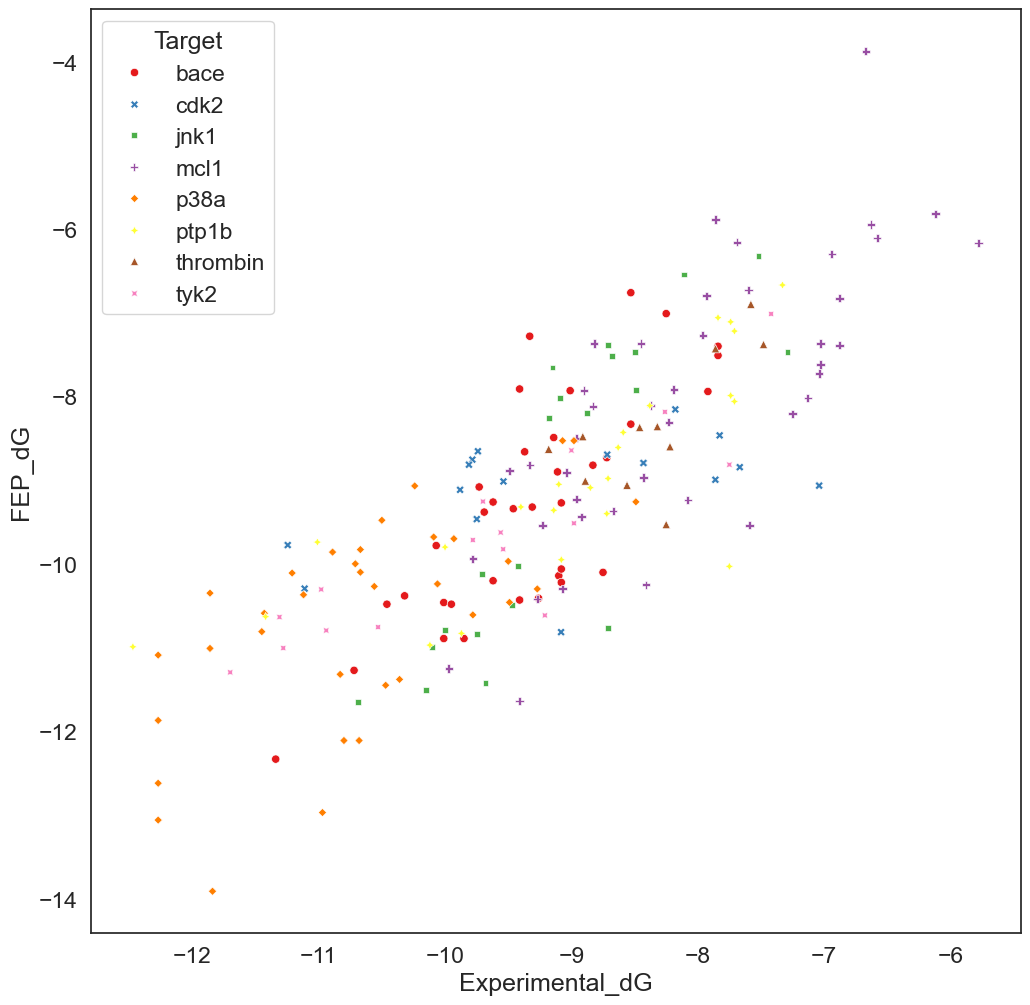

In [40]:
sns.scatterplot(x='Experimental_dG', y='FEP_dG', hue='Target', data=big_df, style='Target', palette='Set1')
# Show plot
plt.show()

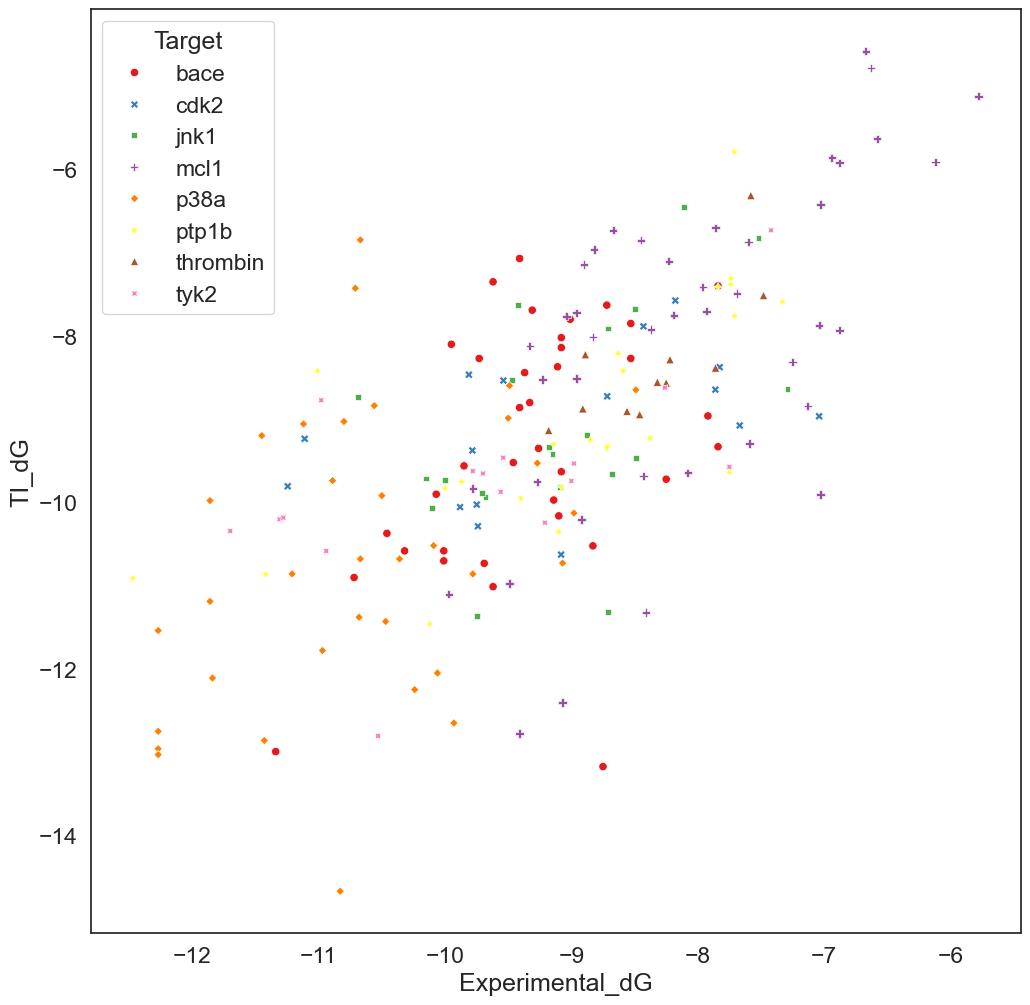

In [148]:
sns.scatterplot(x='Experimental_dG', y='TI_dG', hue='Target', data=big_df, style='Target', palette='Set1')
# Show plot
plt.show()

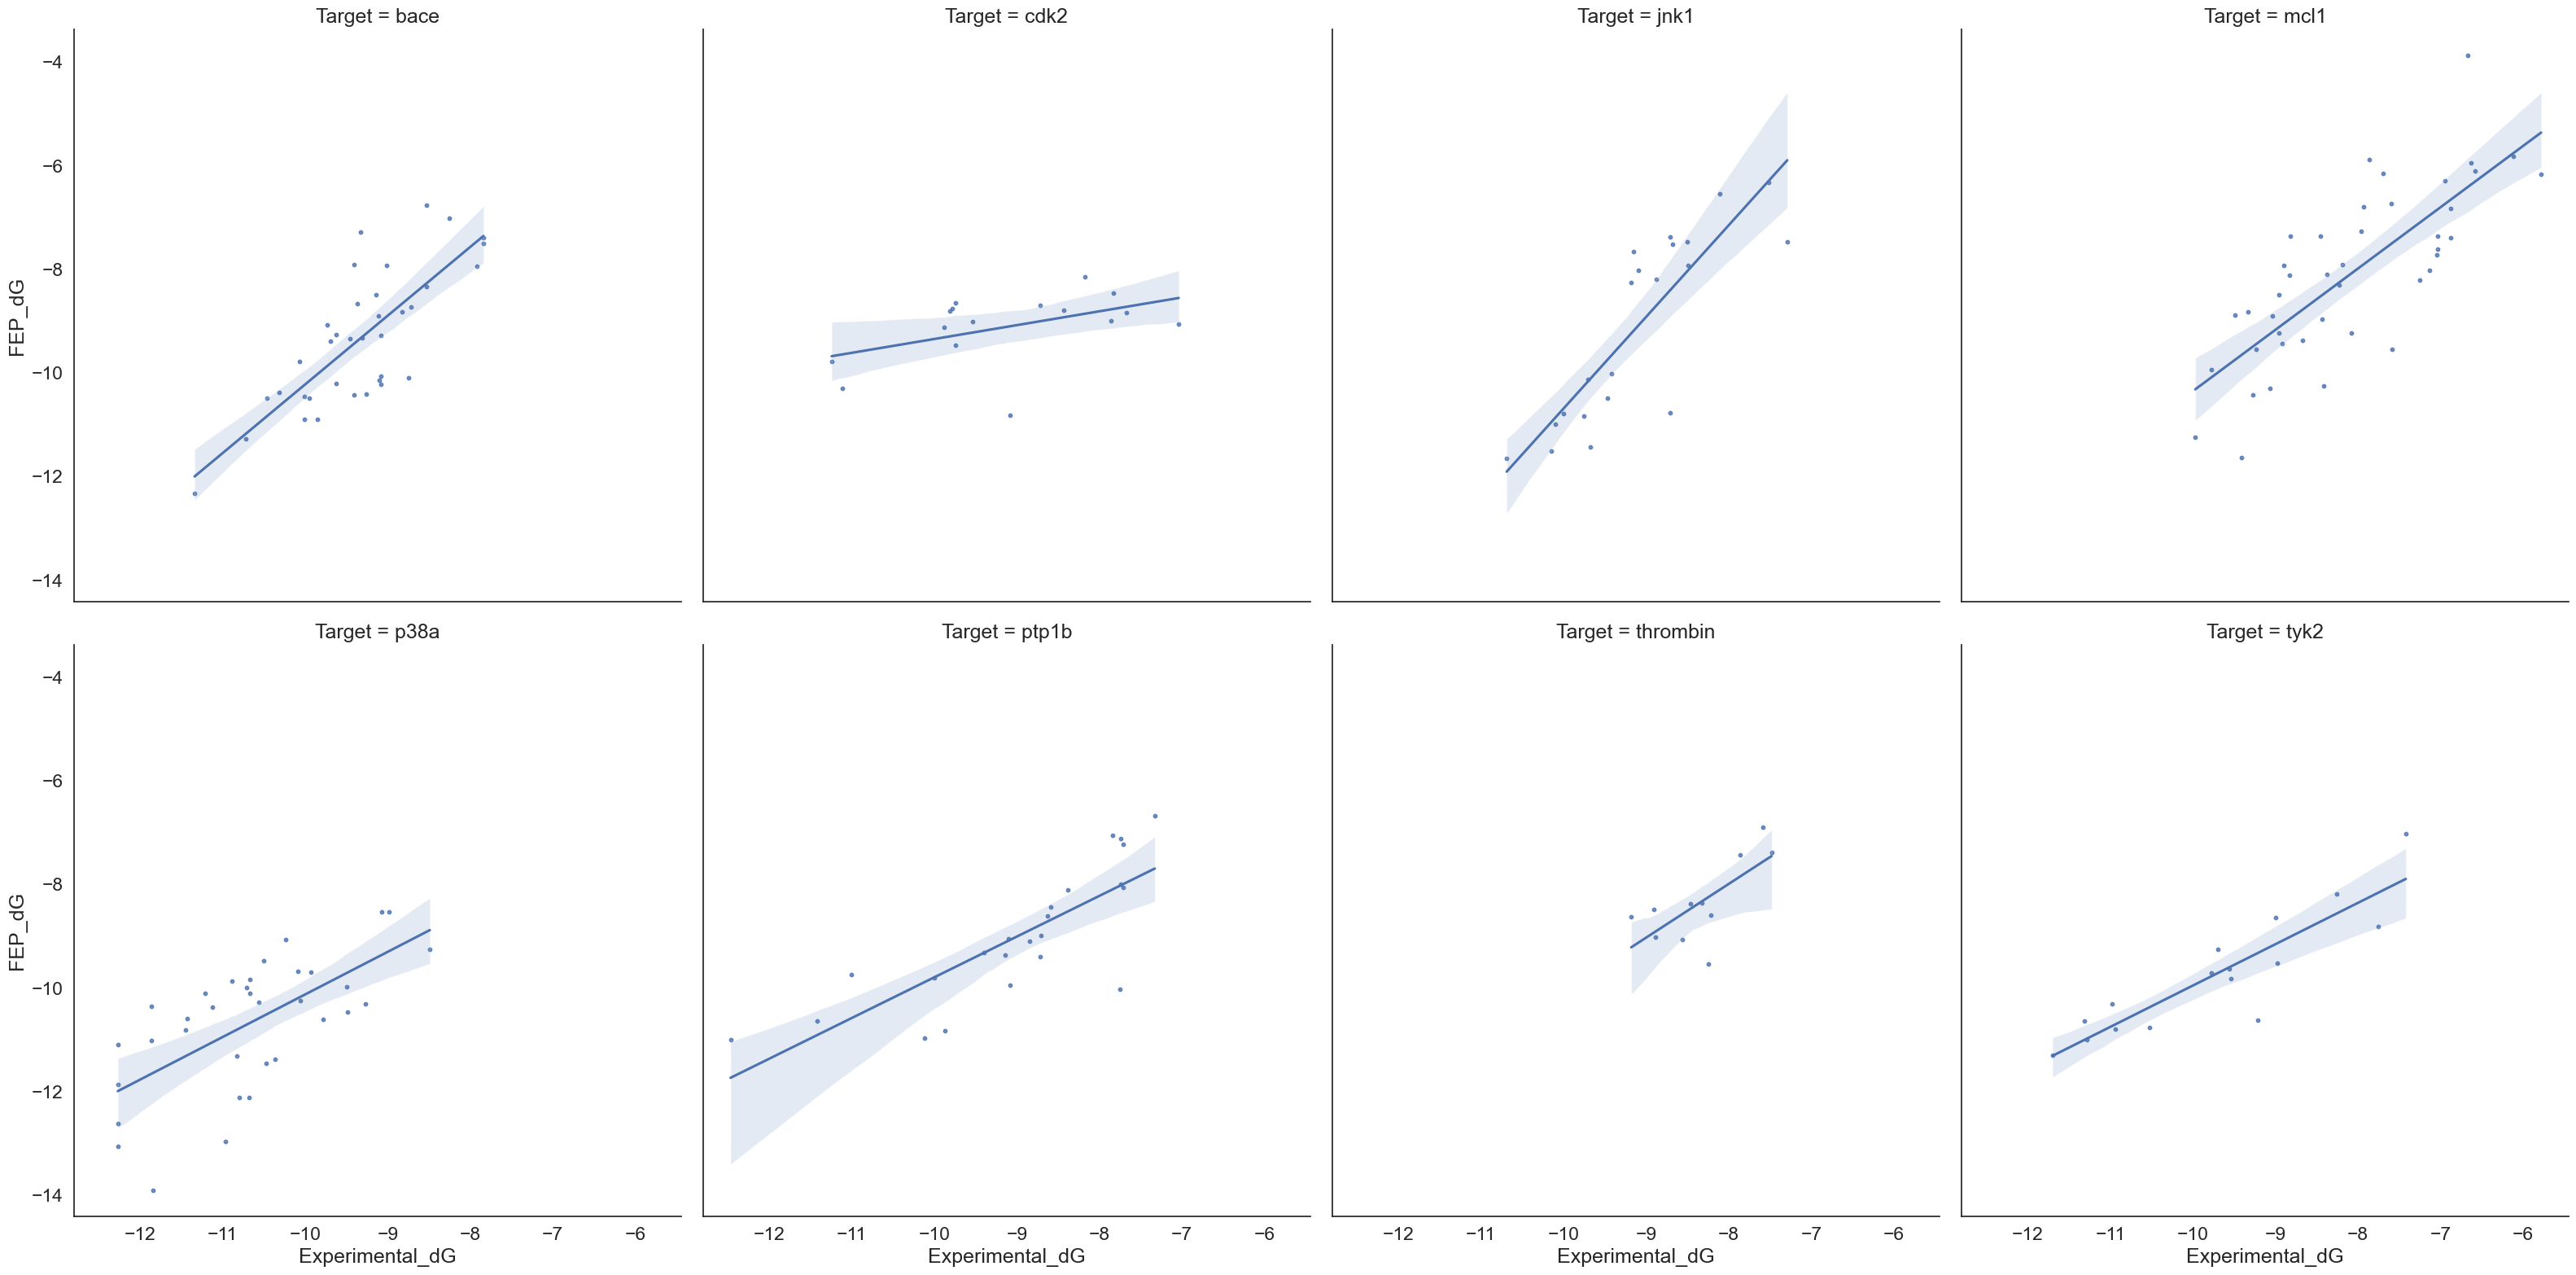

In [42]:
g = sns.FacetGrid(big_df, col='Target', col_wrap=4, height=8)

# Map the regplot function to each subset of the data
g.map(sns.regplot, 'Experimental_dG', 'FEP_dG', scatter_kws={'s':10})

# Show plot
plt.show()

In [43]:
xls_name = "fep-vs-gti-d-G-SI.xlsx"
df_dict = pd.read_excel(xls_name,sheet_name=None,header=None)

def get_data_from_sheet(df_dict, sheet_name, col_names):
    df = df_dict[sheet_name]
    df = df[df.columns[15:18]]
    col_names = ["Experimental_dG","FEP_dG","TI_dG"]
    df.columns = col_names
    df = df.dropna()
    df = df.query("Experimental_dG > -20")
    rows,_ = df.shape
    df.insert(0,"Target",[sheet_name]*rows)
    df.insert(1,"ID",[f"{sheet_name}_{x}" for x in range(0,rows)])
    return df

pd.options.display.float_format = '{:,.2f}'.format

sheet_names = df_dict.keys()
col_names = ["Experimental_dG","FEP_dG","TI_dG"]
big_df = pd.DataFrame(columns=["Target","ID"]+col_names)
for sheet in sheet_names:
    tmp_df = get_data_from_sheet(df_dict,sheet,col_names)
    big_df = pd.concat([big_df, tmp_df])   
big_df.sort_values("Target",inplace=True)

# Extract the columns you need
column_data = big_df['FEP_dG']

# Calculate statistics
mean = column_data.mean()
median = column_data.median()
variance = column_data.var()
std_dev = column_data.std()
min_value = column_data.min()
max_value = column_data.max()

# Print the statistics
print('Mean: ', format(mean, ',.2f'))
print('Median: ', format(median, ',.2f'))
print('Variance: ',format(variance, ',.2f'))
print('Standard Deviation: ', format(std_dev, ',.2f'))
print('Min: ', format(min_value, ',.2f'))
print('Max: ', format(max_value, ',.2f'))

Mean:  -9.20
Median:  -9.25
Variance:  2.52
Standard Deviation:  1.59
Min:  -13.91
Max:  -3.87


/var/folders/qn/1xv8rtz13z55l58_s06hqhhc0000gn/T/ipykernel_29979/1655762281.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat([big_df, tmp_df])


### In this part of the NoteBook, the calculation of Variance and Covariance is reported. The whole data set, as well as some selected molecular targets, will be used to calculate variance.

## *Variance*
### It is the sum of squared deviations from the mean divided by n – 1, where n is the number of data values.
### Therefore, the first statistical quantity to obtain is the mean for all FEP and TI energies and some selected molecular targets.
### Variance can be calculated using the following formula: 

# s**2 = SUM (x- u)**2 / n - 1



In [45]:
df2 = big_df.copy() 
df3 = big_df.copy()
df4 = big_df.copy()
df2.head()

,Target,ID,Experimental_dG,FEP_dG,TI_dG
12,bace,bace_12,-8.53,-6.76,-8.27
30,bace,bace_30,-7.84,-7.40,-7.40
29,bace,bace_29,-9.01,-7.93,-7.80
28,bace,bace_28,-8.25,-7.01,-9.72
27,bace,bace_27,-9.10,-10.14,-10.16


In [46]:
whole_data_fep = df2['FEP_dG'] # Extract the FEP_dG column
whole_data_ti = df3['TI_dG'] # Extract the FEP_dG column
whole_data_exp = df4['Experimental_dG'] # Extract the FEP_dG column

mean_fep_all = whole_data_fep.mean() # Calculate the mean of the FEP_dG column
mean_ti_all = whole_data_ti.mean() # Calculate the mean of the FEP_dG column
mean_exp_all = whole_data_exp.mean() # Calculate the mean of the FEP_dG column

print('Mean FEP all: ', format(mean_fep_all, ',.2f')) # Print the mean of the FEP_dG column
print('Mean TI all: ', format(mean_ti_all, ',.2f')) # Print the mean of the FEP_dG column
print('Mean Exp all: ', format(mean_exp_all, ',.2f')) # Print the mean of the FEP_dG column


Mean FEP all:  -9.20
Mean TI all:  -9.20
Mean Exp all:  -9.20


In [140]:
sum_squared_diff = 0
count = 0

for num in whole_data_fep:
    sum_squared_diff += (num - mean_fep_all)**2
    count += 1

variance = sum_squared_diff / (count - 1)
    
print('squared_deviations_FEP: ', format(sum_squared_diff, ',.2f'))
print('Variance for FEP in all data: ', format(variance, ',.2f'))


squared_deviations_FEP:  499.37
Variance for FEP in all data:  2.52


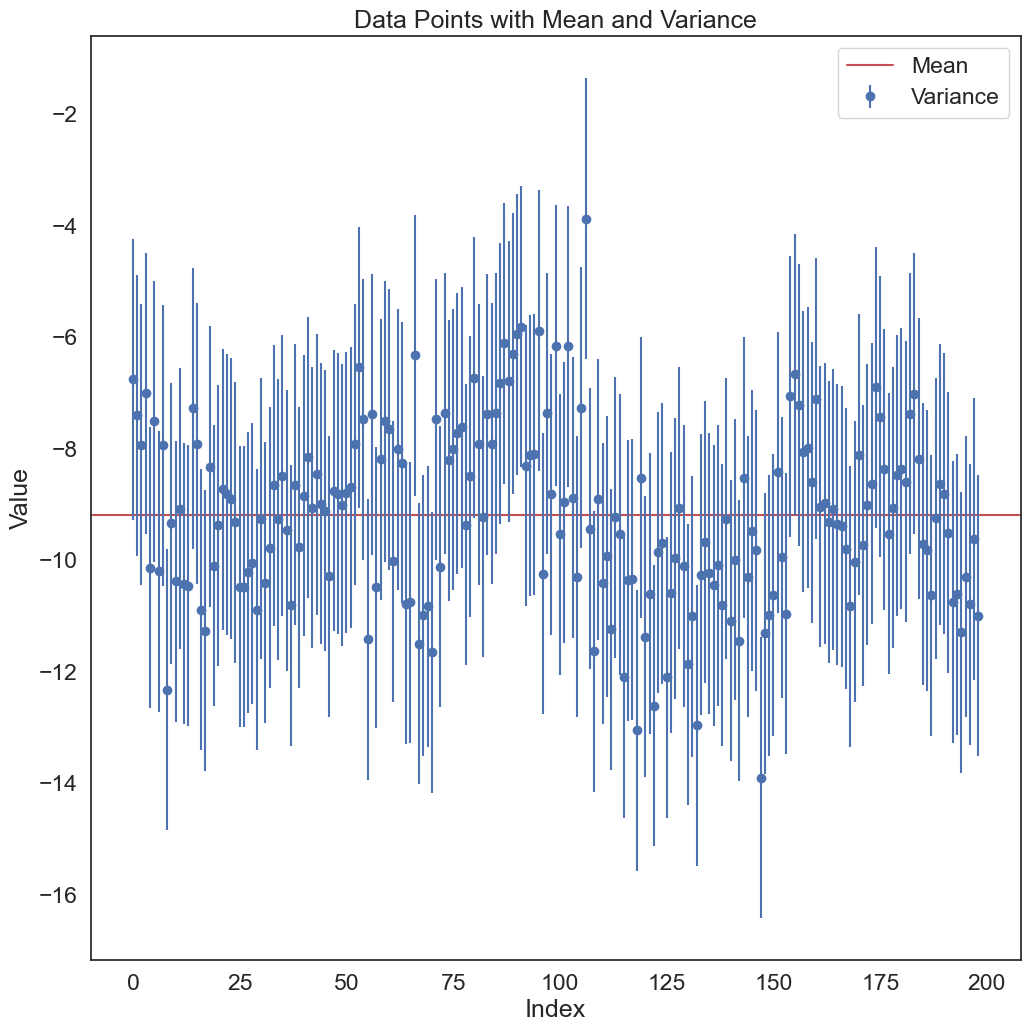

In [48]:
# Plot the mean
plt.axhline(y=mean_fep_all, color='r', linestyle='-', label='Mean')

# Plot the variance as error bars
plt.errorbar(range(len(whole_data_fep)), whole_data_fep, yerr=variance, fmt='o', label='Variance')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Data Points with Mean and Variance')
plt.legend()

# Show the plot
plt.show()

In [138]:
sum_squared_diff = 0
count = 0

for num in whole_data_ti:
    sum_squared_diff += (num - mean_ti_all)**2
    count += 1

variance = sum_squared_diff / (count - 1)
    
print('squared_deviations_TI: ', format(sum_squared_diff, ',.2f'))
print('Variance for TI in all data: ', format(variance, ',.2f'))

squared_deviations_TI:  588.81
Variance for TI in all data:  2.97


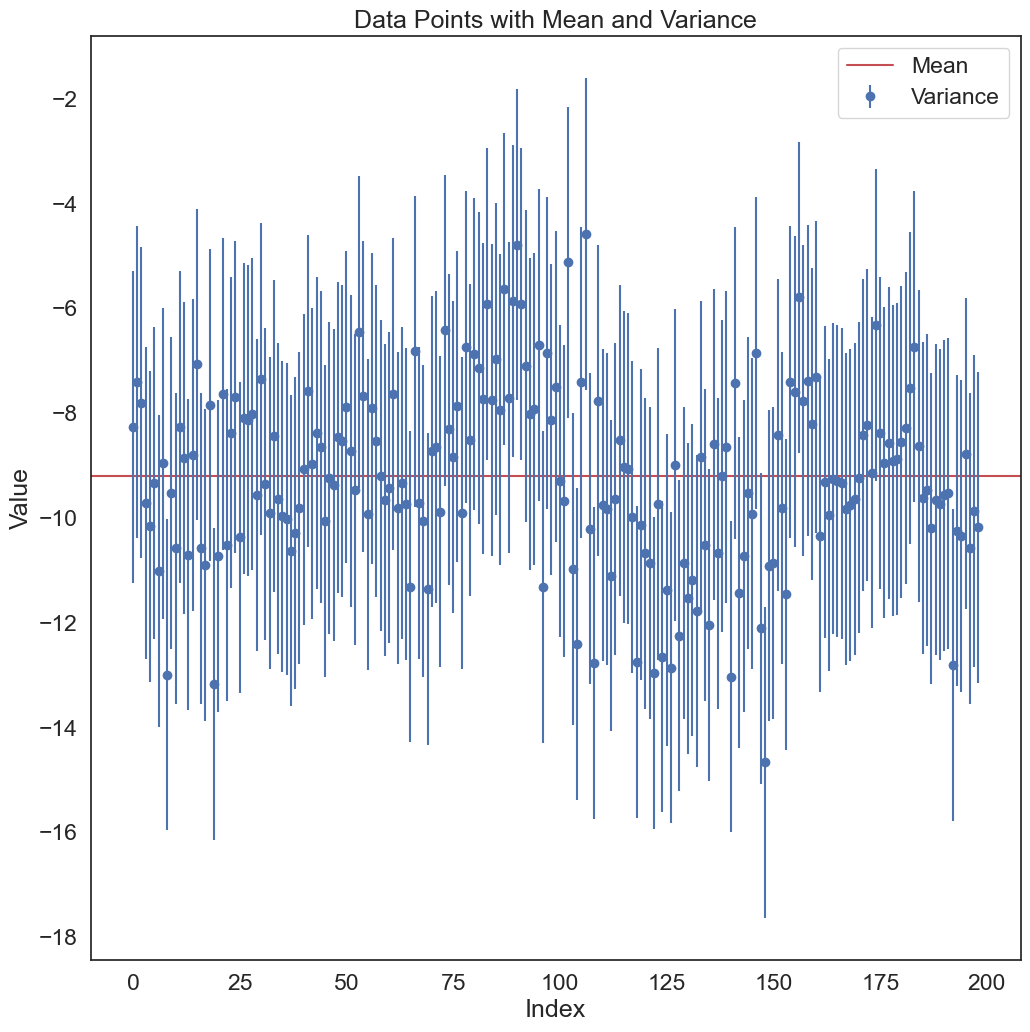

In [50]:
# Plot the mean
plt.axhline(y=mean_ti_all, color='r', linestyle='-', label='Mean')

# Plot the variance as error bars
plt.errorbar(range(len(whole_data_ti)), whole_data_ti, yerr=variance, fmt='o', label='Variance')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Data Points with Mean and Variance')
plt.legend()

# Show the plot
plt.show()

### The covariance measures the relationship between two variables x and z. Denote the mean for each variable by X and Z.
### As with the correlation coefficient, positive values indicate a positive relationship and negative values indicate a negative relationship.
### Covariance can be calculated using the following formula: 

# Sx,z = SUM (x - X)*(z - Z) / n - 1

### Correlation, however, is constrained to be between –1 and 1, whereas covariance is on the same scale as the variables X and Z.


In [134]:
sum_of_diff = 0
count = 0

# Ensure both lists have the same length
if len(whole_data_fep) != len(whole_data_exp):
    raise ValueError("The lists whole_data_fep and whole_data_exp must have the same length")

# Calculate the sum of the product of differences from the mean
for num, num2 in zip(whole_data_fep, whole_data_exp):
    diff_fep = (num - mean_fep_all)
    diff_exp = (num2 - mean_exp_all)
    sum_of_diff += diff_fep * diff_exp
    count += 1

# Calculate the covariance
covariance = sum_of_diff / (count - 1)
    
print(sum_of_diff)
print('Covariance for FEP in all data: ', format(covariance, ',.2f'))

336.95631896084586
Covariance for FEP in all data:  1.70


In [136]:
sum_of_diff = 0
count = 0

# Ensure both lists have the same length
if len(whole_data_ti) != len(whole_data_exp):
    raise ValueError("The lists whole_data_ti and whole_data_exp must have the same length")

# Calculate the sum of the product of differences from the mean
for num, num2 in zip(whole_data_ti, whole_data_exp):
    diff_ti = (num - mean_ti_all)
    diff_exp = (num2 - mean_exp_all)
    sum_of_diff += diff_ti * diff_exp
    count += 1

# Calculate the covariance
covariance = sum_of_diff / (count - 1)

print(sum_of_diff)
print('Covariance for TI in all data: ', format(covariance, ',.2f'))

299.3392678887205
Covariance for TI in all data:  1.51
